In [1]:
import time

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(int(time.time()))
tf.set_random_seed(int(time.time()))

In [2]:
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1):
    # constant is 1 for tanh and 4 for sigmoid activation
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    
    # Try Gamma Distribution
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

In [4]:
class VariationalAutoEncoder(object):
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        # TF Graph Input
        self.x = tf.placeholder(tf.float32, [None, network_architecture['n_input']])
        
        # Create autoencoder network
        self._create_network()
        
        # Define loss function based variational upper-bound and corresponding optimizer
        self._create_loss_optimizer()
        
        # Initialize TF variables
        init = tf.global_variables_initializer()
        
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize auto encoder weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)
        
        # Use recognition network to determine mean and variance of the Gaussian dist. in latent space
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(network_weights['weights_recog'], network_weights['biases_recog'])
        
        # Draw one sample from z from Gaussian distribution
        n_z = self.network_architecture['n_z']
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        
        # z = mu + sigma * epsilon
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        
        # Use generator to determine mean of Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = self._generator_network(network_weights['weights_gener'], network_weights['biases_gener'])
        
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))
        }
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        }
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))
        }
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
    
    def _recognition_network(self, weights, biases):
        # Generate probabilistic decoder which maps inputs onto a normal distribution in latent space. 
        # The transformation is parametrized and can be learned
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean'])
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']), biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)
    
    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) 
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        return x_reconstr_mean
    
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean) + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mean) - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
    
    def partial_fit(self, X):
        """
            Train model based on mini-batch of input data.
            Return cost of mini-batch
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into latent space"""
        return self.sess_run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """Generate data by sampling from latent space. 
        If z_mu is not None, data for this point is generated. 
        Otherwise, z_mu is drawn from prior in latent space."""
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture['n_z'])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})

In [5]:
def train(network_architecture, learning_rate=0.001, batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoEncoder(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    for epoch in range(100):
        avg_cost = 0
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
        return vae
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=100)

('Epoch:', '0001', 'cost=', '175.014753085')


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


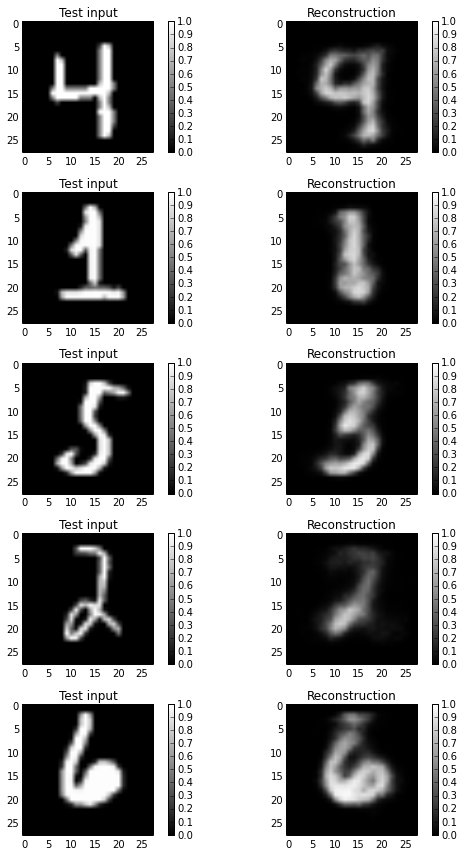

In [6]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_recons]\wtruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()